SPAMBASE DATASET (CLASSIFICATION)
Loading Spambase dataset...
Dataset loaded successfully:
  Features: 4601 samples, 57 features

RIDGE REGRESSION
Optimal lambda: 100
Optimal threshold: 0.44674481309678127
Best accuracy: 0.9081521739130435
Classification Performance:
--------------------------------------------------
Training Accuracy: 0.9082
Test Accuracy: 0.9034

Confusion Matrix:
[[520  38]
 [ 51 312]]

CONFUSION MATRIX


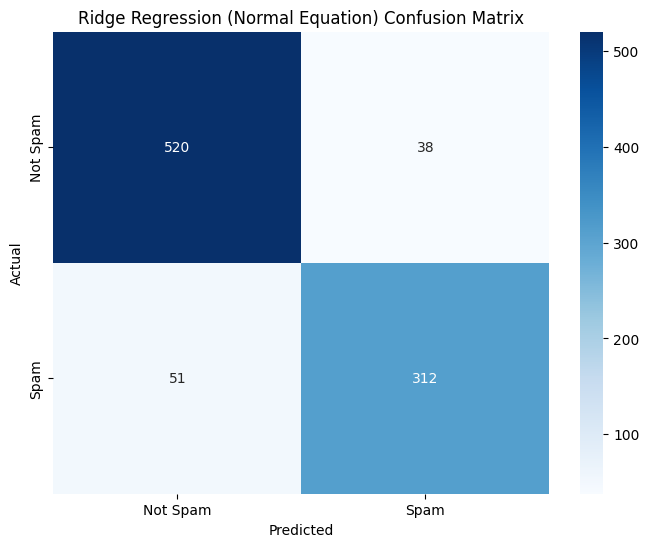


RIDGE REGRESSION using gradient descent
Optimal lambda: 100
Optimal threshold: 0.36245332599271596
Best accuracy: 0.9095108695652174
Classification Performance:
--------------------------------------------------
Training Accuracy: 0.9005
Test Accuracy: 0.8958

Confusion Matrix:
[[491  67]
 [ 29 334]]

CONFUSION MATRIX


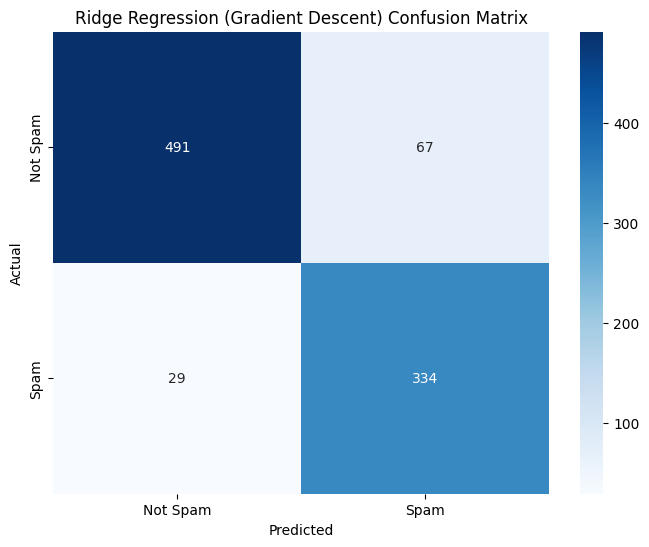


GRADIENT DESCENT LOGISTIC REGRESSION
Optimal learning rate: 1.0
Best accuracy: 0.9290760869565218
Classification Performance:
--------------------------------------------------
Training Accuracy: 0.9291
Test Accuracy: 0.9283

Confusion Matrix:
[[531  27]
 [ 39 324]]

CONFUSION MATRIX


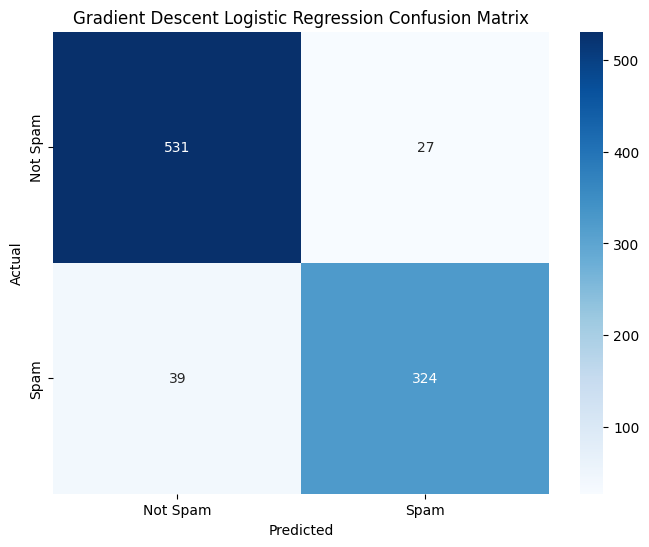


ROC CURVES COMPARISON

AUC Summary:
Ridge Regression AUC: 0.9492
Logistic Regression AUC: 0.9704
HOUSING DATASET (REGRESSION)
Dataset loaded successfully:
  Training set: 433 samples, 13 features
  Testing set: 74 samples, 13 features

RIDGE REGRESSION using normal equations
Optimal lambda: 0.001
Best MSE: 22.08127318929342
Regression Performance:
--------------------------------------------------
Training MSE: 22.0813
Test MSE: 22.6381

RIDGE REGRESSION using gradient descent
Optimal lambda: 0.001
Best MSE: 22.45633938992609
Regression Performance:
--------------------------------------------------
Training MSE: 22.1011
Test MSE: 22.3118


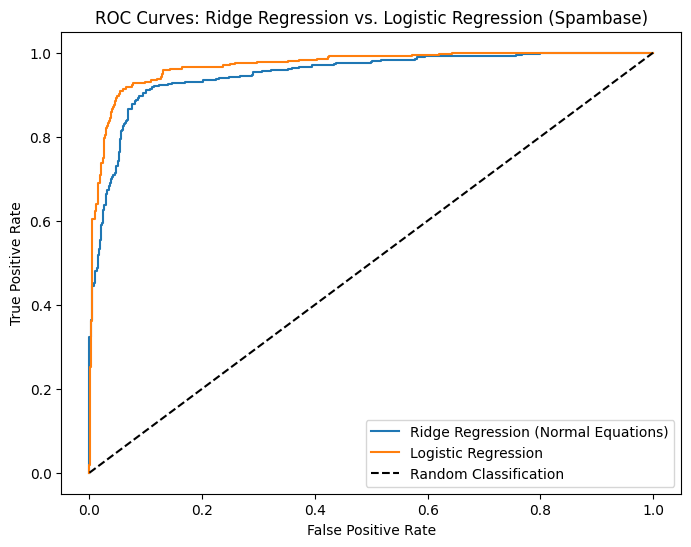

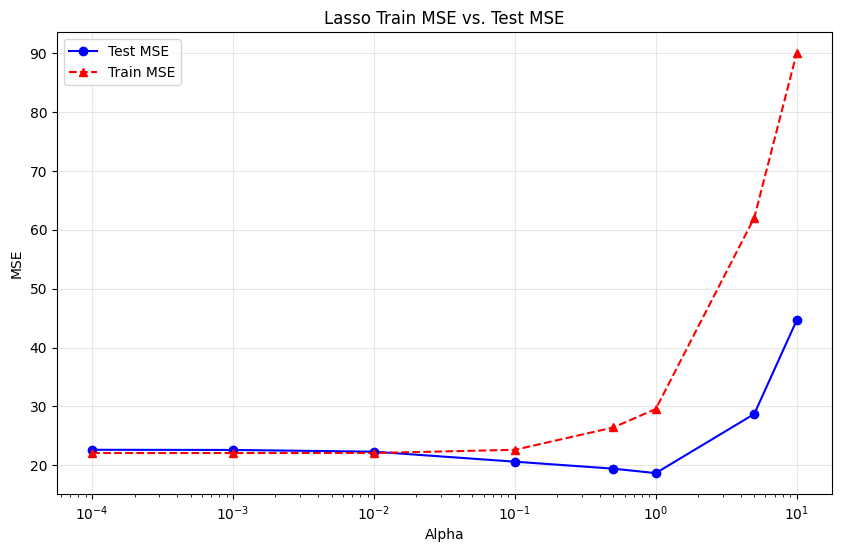

In [4]:
%pip install ucimlrepo

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso


class RidgeRegression:
    """
    Rige Regression Implementation using normal equations
    """
    def __init__(self, lambda_reg = 1.0, fit_intercept = True):
        """
        Parameters:
        -----------
        lambda_reg : float
            Regularization parameter
        fit_intercept : bool
            Whether to fit the intercept (bias) term
        """
        self.lambda_reg = lambda_reg
        self.fit_intercept = fit_intercept
        self.intercept = None
        self.weights = None
        self.coefficients = None

    def add_intercept(self, X):
        """
        Add intercept to the features
        Parameters:
        -----------
        X : numpy array
        """
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def fit(self, X, y):
        """
        Fit the model to the data
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        # Add intercept if needed
        X_with_intercept = X if not self.fit_intercept else self.add_intercept(X)

        # Normal Equation
        n_features = X_with_intercept.shape[1]

        # Create Identitiy
        n_identity = np.identity(n_features)
        if self.fit_intercept:
            n_identity[0, 0] = 0

        # Calculate X^T X
        XTX = X_with_intercept.T @ X_with_intercept

        # add L2-regularization
        XTX_reg = XTX + self.lambda_reg * n_identity

        self.weights = np.linalg.inv(XTX_reg) @ X_with_intercept.T @ y

        if self.fit_intercept:
            self.intercept = self.weights[0]
            self.coefficients = self.weights[1:]
        else:
            self.intercept = 0
            self.coefficients = self.weights

    def predict(self, X):
        """
        Predict the target for the given features
        Parameters:
        -----------
        X : numpy array
            Features
        Returns:
        --------
        y_pred : numpy array
            Predicted targets
        """
        # Predict
        y_pred = X @ self.coefficients + self.intercept

        return y_pred

    def predict_class(self, X, threshold=0.5):
        """
        Predict the class for the given features
        Parameters:
        -----------
        X : numpy array
            Features
        threshold : float
            Threshold for classification
        Returns:
        --------
        y_pred : numpy array
            Predicted classes
        """
        # Predict
        y_pred = self.predict(X)

        # Apply threshold
        return (y_pred >= threshold).astype(int)

class RidgeRegressionGD:
    """
    Ridge Regression Implementation using Gradient Descent
    """
    def __init__(self, lambda_reg = 1.0, learning_rate = 0.01, n_iterations = 1000, fit_intercept = True, tolerance = 1e-5):
        """
        Parameters:
        -----------
        lambda_reg : float
            Regularization parameter
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of iterations for gradient descent
        fit_intercept : bool
        """
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.fit_intercept = fit_intercept
        self.intercept = None
        self.weights = None
        self.cost_history = []
        self.tolerance = tolerance
        self.coefficients = None

    def add_intercept(self, X):
        """
        Add intercept to the features
        Parameters:
        -----------
        X : numpy array
        """
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def cost_function(self, X, y, weights):
        """
        Calculate the cost function (MSE + L2 regularization)
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        n_samples = X.shape[0]

        # Predictions
        y_pred = X @ weights

        mse = (1 / (2 * n_samples)) * np.sum((y_pred - y) ** 2)

        if self.fit_intercept:
            l2_reg = (self.lambda_reg / (2 * n_samples)) * np.sum(weights[1:] ** 2)
        else:
            l2_reg = (self.lambda_reg / (2 * n_samples)) * np.sum(weights ** 2)

        return mse + l2_reg

    def gradient(self, X, y, weights):
        """
        Calculate the gradient of the cost function
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        n_samples = X.shape[0]

        # Predictions
        y_pred = X @ weights

        # Gradient
        gradient = (1 / n_samples) * X.T @ (y_pred - y)

        # Add L2 Regularization gradient
        reg_gradient = (self.lambda_reg / n_samples) * weights
        if self.intercept:
            reg_gradient[0] = 0

        return gradient + reg_gradient

    def check_convergence(self, iteration):
        """
        Check for convergence
        Parameters:
        -----------
        iteration : int
            Current iteration
        Returns : bool
            True if converged, False otherwise
        """
        if iteration < 1:
            return False

        # Calculate the change
        change = abs(self.cost_history[-1] - self.cost_history[-2])

        return change < self.tolerance


    def fit(self, X, y):
        """
        Fit the model to the data
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        X_with_intercept = X if not self.fit_intercept else self.add_intercept(X)

        # Initialize weights
        n_features = X_with_intercept.shape[1]
        self.weights = np.zeros(n_features)

        # Gradient Descent
        for i in range(self.n_iterations):
            # Get gradient
            gradient = self.gradient(X_with_intercept, y, self.weights)

            # Update weights
            self.weights -= self.learning_rate * gradient

            # Calculate cost
            cost = self.cost_function(X_with_intercept, y, self.weights)

            self.cost_history.append(cost)

            # Check for convergence
            if self.check_convergence(i):
                break

        if self.fit_intercept:
            self.intercept = self.weights[0]
            self.coefficients = self.weights[1:]
        else:
            self.intercept = 0
            self.coefficients = self.weights

    def predict(self, X):
        """
        Predict the target for the given features
        Parameters:
        -----------
        X : numpy array
            Features
        Returns:
        --------
        y_pred : numpy array
            Predicted targets
        """
        return X @ self.coefficients + self.intercept

    def predict_class(self, X, threshold = 0.5):
        """
        Predict the class for the given features
        Parameters:
        -----------
        X : numpy array
            Features
        threshold : float
            Threshold for classification
        Returns:
        --------
        y_pred : numpy array
            Predicted classes
        """
        y_pred = self.predict(X)
        return (y_pred >= threshold).astype(int)

class LogisticRegressionGD:
    """
    Logistic Regression Implementation using Gradient Descent
    """
    def __init__(self, learning_rate = 0.01, n_iterations = 1000, tolerance = 1e-5, fit_intercept = True):
        """
        Parameters:
        -----------
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of iterations for gradient descent
        tolerance : float
            Tolerance for convergence
        fit_intercept : bool
            Whether to fit the intercept (bias) term
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tolerance = tolerance
        self.fit_intercept = fit_intercept
        self.intercept = None
        self.weights = None
        self.cost_history = []

    def sigmoid(self, z):
        """
        Sigmoid function
        """
        # clip to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def add_intercept(self, X):
        """
        Add intercept to the features
        Parameters:
        -----------
        X : numpy array
        """
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def cost_function(self, X, y, weights):
        """
        Calculate the cost function
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        n_samples = X.shape[0]

        # Predictions
        y_pred = self.sigmoid(X @ weights)

        epsilon = 1e-7
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        cost = (-1 / n_samples) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

        return cost

    def gradient(self, X, y, weights):
        """
        Calculate the gradient of the cost function
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        n_samples = X.shape[0]

        # Predictions
        y_pred = self.sigmoid(X @ weights)

        # Gradient
        gradient = (1 / n_samples) * X.T @ (y_pred - y)

        return gradient

    def check_convergence(self, iteration):
        """
        Check for convergence
        Parameters:
        -----------
        iteration : int
            Current iteration
        Returns : bool
            True if converged, False otherwise
        """
        if iteration < 1:
            return False

        # Calculate the change
        change = abs(self.cost_history[-1] - self.cost_history[-2])

        return change < self.tolerance

    def fit(self, X, y):
        """
        Fit the model to the data
        Parameters:
        -----------
        X : numpy array
            Features
        y : numpy array
            Targets
        """
        X_with_intercept = X if not self.fit_intercept else self.add_intercept(X)

        # Initialize weights
        n_features = X_with_intercept.shape[1]
        self.weights = np.zeros(n_features)

        self.cost_history = []

        for i in range(self.n_iterations):
            # Get gradient
            gradient = self.gradient(X_with_intercept, y, self.weights)

            # Update weights
            self.weights -= self.learning_rate * gradient

            # Calculate cost
            cost = self.cost_function(X_with_intercept, y, self.weights)
            self.cost_history.append(cost)

            # Check for convergence
            if self.check_convergence(i):
                break

    def predict(self, X, threshold = 0.5):
        """
        Predict the target for the given features
        Parameters:
        -----------
        X : numpy array
            Features
        Returns:
        --------
        y_pred : numpy array
            Predicted targets
        """
        X = X if not self.fit_intercept else self.add_intercept(X)
        return (self.sigmoid(X @ self.weights) >= threshold).astype(int)


def find_optimal_lambda_classification_RR(X_train, y_train):
    """
    Find the optimal lambda and threshold for Ridge Regression
    """
    lambdas = [0.001, 0.01, 0.1, 1, 10, 100]

    best_lambda = None
    best_threshold = None
    best_accuracy = 0

    for lambda_reg in lambdas:
        model = RidgeRegression(lambda_reg=lambda_reg)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)

        thresholds = np.linspace(y_pred.min(), y_pred.max(), 50)

        for threshold in thresholds:
            y_pred_class = (y_pred >= threshold).astype(int)
            accuracy = accuracy_score(y_train, y_pred_class)

            if accuracy > best_accuracy:
                best_lambda = lambda_reg
                best_threshold = threshold
                best_accuracy = accuracy

    return best_lambda, best_threshold, best_accuracy


def find_optimal_lambda_regression_RR(X_train, y_train):
    """
    Find the optimal lambda for Ridge Regression
    """
    lambdas = [0.001, 0.01, 0.1, 1, 10, 100]

    best_lambda = None
    best_mse = float('inf')

    for lambda_reg in lambdas:
        model = RidgeRegression(lambda_reg=lambda_reg)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)

        mse = mean_squared_error(y_train, y_pred)

        if mse < best_mse:
            best_lambda = lambda_reg
            best_mse = mse

    return best_lambda, best_mse

def find_optimal_hyperparameters_classification_GD(X_train, y_train):
    """
    Find the optimal hyperparameters for Ridge Regression using Gradient Descent
    """
    lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
    learning_rates = [0.0001, 0.001, 0.01]

    best_lambda = None
    best_threshold = None
    best_learning_rate = None
    best_accuracy = 0

    for learning_rate in learning_rates:
        for lambda_reg in lambdas:
            model = RidgeRegressionGD(lambda_reg = lambda_reg, learning_rate = learning_rate)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_train)

            thresholds = np.linspace(y_pred.min(), y_pred.max(), 50)

            for threshold in thresholds:
                y_pred_class = (y_pred >= threshold).astype(int)
                accuracy = accuracy_score(y_train, y_pred_class)

                if accuracy > best_accuracy:
                    best_lambda = lambda_reg
                    best_threshold = threshold
                    best_learning_rate = learning_rate
                    best_accuracy = accuracy

    return best_lambda, best_threshold, best_learning_rate, best_accuracy

def find_optimal_hyperparameters_gression_GD(X_train, y_train):
    """
    Find the optimal hyperparameters for Ridge Regression using Gradient Descent
    """
    lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
    learning_rates = [0.0001, 0.001, 0.01]

    best_lambda = None
    best_learning_rate = None
    best_mse = float('inf')

    for learning_rate in learning_rates:
        for lambda_reg in lambdas:
            model = RidgeRegressionGD(lambda_reg = lambda_reg, learning_rate = learning_rate)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_train)

            mse = mean_squared_error(y_train, y_pred)

            if mse < best_mse:
                best_lambda = lambda_reg
                best_learning_rate = learning_rate
                best_mse = mse

    return best_lambda, best_learning_rate, best_mse

def find_optimal_learning_rate(X_train, y_train):
    """
    Find the optimal learning rate for Ridge Regression using Gradient Descent
    """
    learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

    best_learning_rate = None
    best_accuracy = 0

    for learning_rate in learning_rates:
        model = LogisticRegressionGD(learning_rate = learning_rate)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_train)

        accuracy = accuracy_score(y_train, y_pred)

        if accuracy > best_accuracy:
            best_learning_rate = learning_rate
            best_accuracy = accuracy

    return best_learning_rate, best_accuracy


def fetch_spambase_data():
    """
    Fetch Spambase dataset from UCI repository
    Returns:
    --------
    X : numpy array
        Features
    y : numpy array
        Targets
    """
    spambase = fetch_ucirepo(id=94)
    # Extract features and targets
    X = spambase.data.features.values
    y = spambase.data.targets.values.ravel()
    return X, y

def fetch_housing_data():
    """
    Fetch Housing dataset from predefined training and testing files

    Returns:
    --------
    X_train : numpy array
        Training features
    y_train : numpy array
        Training targets
    X_test : numpy array
        Testing features
    y_test : numpy array
        Testing targets
    feature_names : list
        List of feature names
    """
    # URLs for training and testing data
    train_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/housing_train.txt"
    test_url = "https://www.khoury.northeastern.edu/home/vip/teach/MLcourse/data/housing_test.txt"

    # Feature names
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

    # Load training data
    train_response = requests.get(train_url)
    train_response.raise_for_status()  # Raise an exception for HTTP errors
    train_data = pd.read_csv(StringIO(train_response.text), sep="\s+", header=None)
    train_data.columns = feature_names

    # Load testing data
    test_response = requests.get(test_url)
    test_response.raise_for_status()
    test_data = pd.read_csv(StringIO(test_response.text), sep="\s+", header=None)
    test_data.columns = feature_names

    # Extract features and targets
    X_train = train_data.iloc[:, :-1].values
    y_train = train_data.iloc[:, -1].values

    X_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values

    return X_train, y_train, X_test, y_test, feature_names

def evaluate_classification(y_train, y_pred_train, y_test, y_pred_test):
    """
    Evaluate classification performance
    """
    print("Classification Performance:")
    print("-" * 50)
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))

def evaluate_regression(y_train, y_pred_train, y_test, y_pred_test):
    """
    Evaluate regression performance
    """
    print("Regression Performance:")
    print("-" * 50)
    print(f"Training MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
    print(f"Test MSE: {mean_squared_error(y_test, y_pred_test):.4f}")

def draw_confusion_matrix(y_test, y_pred, title):
    """
    Draw confusion matrix
    """
    print("\n" + "="*50)
    print("CONFUSION MATRIX")
    print("="*50)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


def test_spambase_data():
    """
    Test Spambase dataset
    """
    print("="*70)
    print("SPAMBASE DATASET (CLASSIFICATION)")
    print("="*70)

    # Fetch data
    print("Loading Spambase dataset...")
    X, y = fetch_spambase_data()

    print(f"Dataset loaded successfully:")
    print(f"  Features: {X.shape[0]} samples, {X.shape[1]} features")

    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ##################################################
    # Linear Ridge Regression using normal equations #
    ##################################################

    print("\n" + "="*70)
    print("RIDGE REGRESSION")
    print("="*70)

    best_lambda, best_threshold, best_accuracy = find_optimal_lambda_classification_RR(X_train, y_train)

    print(f"Optimal lambda: {best_lambda}")
    print(f"Optimal threshold: {best_threshold}")
    print(f"Best accuracy: {best_accuracy}")

    model = RidgeRegression(lambda_reg = best_lambda)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict_class(X_train, threshold = best_threshold)
    y_pred_test = model.predict_class(X_test, threshold = best_threshold)

    # Evaluate
    evaluate_classification(y_train, y_pred_train, y_test, y_pred_test)

    # Confusion Matrix for Ridge Regression
    draw_confusion_matrix(y_test, y_pred_test, "Ridge Regression (Normal Equation) Confusion Matrix")

    # Get probability score and auc
    y_pred_value = model.predict(X_test)
    y_score_ridge = 1 / (1 + np.exp(-y_pred_value))
    auc_ridge = roc_auc_score(y_test, y_score_ridge)

    ##################################################
    # Linear Ridge Regression using gradient descent #
    ##################################################

    print("\n" + "="*70)
    print("RIDGE REGRESSION using gradient descent")
    print("="*70)

    best_lambda, best_threshold, best_learning_rate, best_accuracy = find_optimal_hyperparameters_classification_GD(X_train, y_train)

    print(f"Optimal lambda: {best_lambda}")
    print(f"Optimal threshold: {best_threshold}")
    print(f"Best accuracy: {best_accuracy}")

    model = RidgeRegressionGD(lambda_reg = best_lambda, learning_rate = best_learning_rate, n_iterations = 5000, tolerance = 1e-7)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict_class(X_train, threshold = best_threshold)
    y_pred_test = model.predict_class(X_test, threshold = best_threshold)

    # Evaluate
    evaluate_classification(y_train, y_pred_train, y_test, y_pred_test)

    # Confusion Matrix for Ridge Regression
    draw_confusion_matrix(y_test, y_pred_test, "Ridge Regression (Gradient Descent) Confusion Matrix")

    ########################################
    # Gradient Descent Logistic Regression #
    ########################################

    print("\n" + "="*70)
    print("GRADIENT DESCENT LOGISTIC REGRESSION")
    print("="*70)

    best_learning_rate, best_accuracy = find_optimal_learning_rate(X_train, y_train)

    print(f"Optimal learning rate: {best_learning_rate}")
    print(f"Best accuracy: {best_accuracy}")

    model = LogisticRegressionGD(learning_rate = best_learning_rate, n_iterations = 1000, tolerance = 1e-5)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate
    evaluate_classification(y_train, y_pred_train, y_test, y_pred_test)

    # Confusion Matrix for Logistic Regression
    draw_confusion_matrix(y_test, y_pred_test, "Gradient Descent Logistic Regression Confusion Matrix")

    # Get probablity score and auc
    X_test = X_test if not model.fit_intercept else model.add_intercept(X_test)
    y_score_logistic = model.sigmoid(X_test @ model.weights)
    auc_logistic = roc_auc_score(y_test, y_score_logistic)

    ##########################
    # ROC CURVES COMPARISON  #
    ##########################

    print("\n" + "="*70)
    print("ROC CURVES COMPARISON")
    print("="*70)

    plt.figure(figsize=(8, 6))

    # Plot ROC curve for Ridge Regression (Normal Equations)
    fpr, tpr, _ = roc_curve(y_test, y_score_ridge)
    plt.plot(fpr, tpr, label='Ridge Regression (Normal Equations)')

    # Plot ROC curve for Logsitic Regression
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    plt.plot(fpr, tpr, label='Logistic Regression')

    # Plot random classification line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classification')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Ridge Regression vs. Logistic Regression (Spambase)')
    plt.legend()

    # Output AUC result
    print(f"\nAUC Summary:")
    print(f"Ridge Regression AUC: {auc_ridge:.4f}")
    print(f"Logistic Regression AUC: {auc_logistic:.4f}")


def test_housing_data():
    """
    Test Housing dataset
    """
    print("="*70)
    print("HOUSING DATASET (REGRESSION)")
    print("="*70)

    # Load the Housing dataset
    X_train, y_train, X_test, y_test, feature_names = fetch_housing_data()

    print(f"Dataset loaded successfully:")
    print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"  Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ##################################################
    # Linear Ridge Regression using normal equations #
    ##################################################

    # Find optimal lambda
    best_lambda, best_mse = find_optimal_lambda_regression_RR(X_train, y_train)

    print("\n" + "="*70)
    print("RIDGE REGRESSION using normal equations")
    print("="*70)

    print(f"Optimal lambda: {best_lambda}")
    print(f"Best MSE: {best_mse}")

    model = RidgeRegression(lambda_reg = best_lambda)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate
    evaluate_regression(y_train, y_pred_train, y_test, y_pred_test)

    ##################################################
    # Linear Ridge Regression using gradient descent #
    ##################################################

    # Find optimal hyperparameters
    best_lambda, best_learning_rate, best_mse = find_optimal_hyperparameters_gression_GD(X_train, y_train)

    print("\n" + "="*70)
    print("RIDGE REGRESSION using gradient descent")
    print("="*70)

    print(f"Optimal lambda: {best_lambda}")
    print(f"Best MSE: {best_mse}")

    model = RidgeRegressionGD(lambda_reg = best_lambda, n_iterations = 5000, learning_rate = best_learning_rate, tolerance = 1e-5)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate
    evaluate_regression(y_train, y_pred_train, y_test, y_pred_test)

    ####################################
    # L1-regularized Linear Regression #
    ####################################

    # Load data again
    X_train, y_train, X_test, y_test, feature_names = fetch_housing_data()

    # Normalizes all data
    X_all = np.vstack([X_train, X_test])
    scaler = StandardScaler()
    scaler.fit(X_all)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Try L1 penalty values
    alpha_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
    train_mse_list, test_mse_list = [], []

    for alpha in alpha_values:
        # Train
        model = Lasso(alpha = alpha, max_iter = 5000)
        model.fit(X_train_scaled, y_train)

        # Predict
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Compute MSE
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)

        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)

    # plot
    plt.figure(figsize=(10, 6))
    plt.semilogx(alpha_values, test_mse_list, 'b-o', label='Test MSE')
    plt.semilogx(alpha_values, train_mse_list, 'r--^', label='Train MSE')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.title('Lasso Train MSE vs. Test MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


if __name__ == "__main__":
    test_spambase_data()
    test_housing_data()




| Dataset | Decision Tree Regression | Linear Regression (Normal Equations) | Linear Ridge Regression (Normal Equations) | Linear Regression (Gradient Descent) | Logistic Regression (Gradient Descent) |
|---------|-------------------------|--------------------------------------|-------------------------------------------|-------------------------------------|---------------------------------------|
| Spambase | Train ACC: 95.46%<br>Test ACC: 92.46%| Train ACC: 91.12%<br>Test ACC: 90.87% | Train ACC: 90.82%<br>Test ACC: 90.34% | Train ACC: 90.95%<br>Test ACC: 89.58% | Train ACC: 92.91%<br>Test ACC: 92.83% |
| Housing | Train MSE: 6.9846<br>Test MSE: 34.2883 | Train MSE: 22.0813<br>Test MSE: 22.6383 | Train MSE: 22.0813<br>Test MSE: 22.6381 | Train MSE: 22.1011<br>Test MSE: 22.3118 | N/A |